In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd ..

/Users/AchilleTalon/Documents/GitHub/ice-accummulation-M17


## Importing useful modules

We start by importing timeseries analysis modules, plotting and object handling libraries, some of which are locally defined in the scripts repository.

In [3]:
import numpy as np
import xarray as xr
import pyleoclim as pyleo
import matplotlib.pyplot as plt
import pandas as pd
import urllib3
from bs4 import BeautifulSoup
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

import scripts.OxcalReader as ox

pyleo.set_style('journal')  # set the visual style

## Oak reconstruction central Europe, PDSi.

In [4]:
# first we read the url from the NOAA page to get the data
url = 'https://www.ncei.noaa.gov/pub/data/paleo/treering/reconstructions/europe/buntgen2021scpdsi.txt'
http = urllib3.PoolManager()

response = http.request('GET', url)
soup = BeautifulSoup(response.data)          # parse and decode the response
data = soup.decode_contents().split('\r\n')  # a list of lines

Now we can transform this list into a nice pyleoSeries object.

In [5]:
d = []

for i in data:
    if (i.startswith('#') == False) & (i.startswith('##') == False):
        if i.startswith('year') == False:
            
            line = i.split('\t')
            d.append(line)
        else:
            header = i.split('\t')

scPDSI = pyleo.Series(time = [i[0] for i in d[:-2]], value = [i[1] for i in d[:-2]], 
                      time_name='Calendar Year',time_unit='BCE/CE',
                     value_name='scPDSI', value_unit=None)

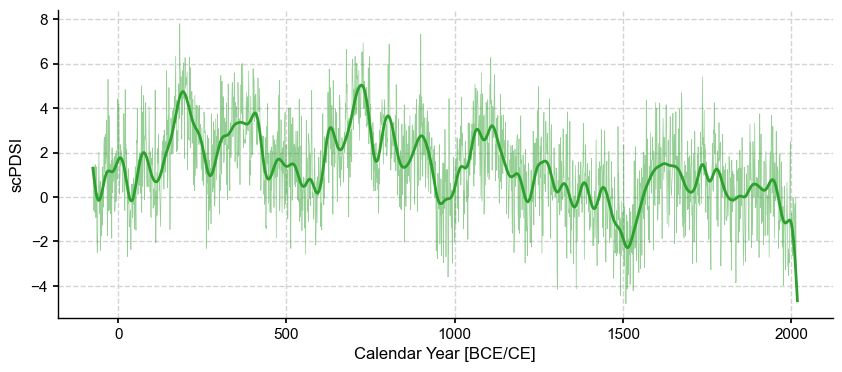

In [6]:
fig, ax = scPDSI.plot(mute = True, linewidth = 0.5, color = 'C2',**{'alpha':0.5})

scPDSI.filter(cutoff_freq=1/50, method = 'butterworth').plot(ax = ax, color = 'C2')
pyleo.showfig(fig, close = True)

### Old World Drought Atlas 

We import the nicely spatially resolved Old World Drought Atlas by [Cook (2015)](https://doi.org/10.1126/sciadv.1500561). Cells are 0.5° x 0.5° large. 

In [7]:
# read the Old World Drought Atlas (Cook, 2015)
ds = xr.open_dataset('../../../../../Volumes/Tanguy Main/Ice_in_caves/cave_data/owda.nc')
print(ds)

<xarray.Dataset>
Dimensions:  (lat: 88, lon: 114, time: 2013)
Coordinates:
  * lon      (lon) float64 -11.75 -11.25 -10.75 -10.25 ... 43.75 44.25 44.75
  * lat      (lat) float64 27.25 27.75 28.25 28.75 ... 69.25 69.75 70.25 70.75
  * time     (time) float64 0.0 1.0 2.0 3.0 ... 2.01e+03 2.011e+03 2.012e+03
Data variables:
    pdsi     (lon, lat, time) float64 ...
Attributes:
    creation_date:  10-Mar-2015 15:53:08
    Description:    Reconstructed PDSI for Europe-Mediterranean Region (OWDA ...


In [8]:
lon = ds['lon'].values
lat = ds['lat'].values
pdsi = ds['pdsi']

Now we select a subset of the data, a square of 4 x 4 cells, centered over 13.5°E and 46.5° N, spanning 12.5-14.5°E and 45.5-47.5°N. Those indices in the lon and lat coordiantes of the dataset are 49:53 and 37:41.

In [9]:
# average hydroclimate conditions between: 12.5-14.5°E and 45.5-47.5°N.
mean = pdsi[49:53,37:41,:].mean(axis = (0,1))
ts_mean = pyleo.Series(value = mean.values,
                       time = mean.time,
                       time_unit='Years CE',
                       value_unit ='unitless',
                       value_name='JJA Palmer Drought\nSeverity I')

Let's a have quick look at this record, using the capabilities of the pyleoclim library to create a 60-year filter.

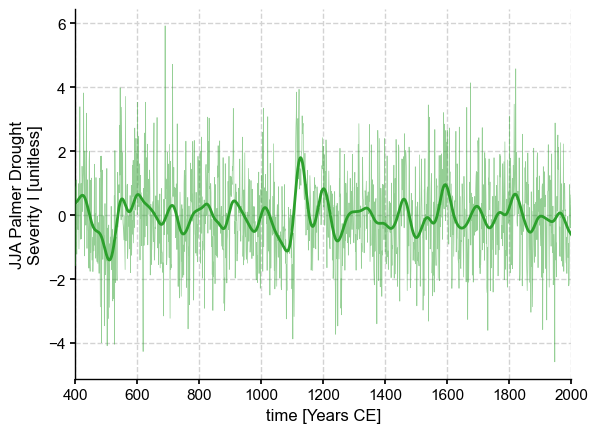

In [10]:
# a quick plot of the drought index. 
fig, axPDSI = plt.subplots()
ts_mean.plot(mute = True,color = 'C2',xlim= (400,2000),linewidth=0.5,alpha = 0.5,zorder = 10,ax = axPDSI)

ts_mean.filter(cutoff_freq=1/60,method = 'butterworth').plot(ax = axPDSI,color = 'C2')

pyleo.showfig(fig, close = True)

# 2500 year history of climate history and human susceptibility

Now we read proxy data derived from tree-ring sequences in France/Germany/Austria/Switzerland and compiled in a dataset. A quantitative reconstruction of [Büntgen (2011)](https://doi.org/10.1126/science.1197175)

In [11]:
# temperature anomaly (Buentgen 2011)
buentgen = pd.read_csv("data/proxies/Buentgen_clean.csv")

# convert JJA temperatures to pyleo.Series object.
ts_bu = pyleo.Series(time = buentgen['Year'],
                     time_unit = 'Years CE',
                     value = buentgen['TempJJA'],
                     value_name='JJA temperature\nAnomaly',
                     value_unit = '°C')

# convert AMJ Precipitation record to pyleo.Series object
ts_bu_pp = pyleo.Series(time = buentgen['Year'],
                        time_unit = 'Years CE',
                        value = buentgen['PrecipAMJ'],
                        value_name='AMJ precipitation\nTotals',
                        value_unit = 'mm')

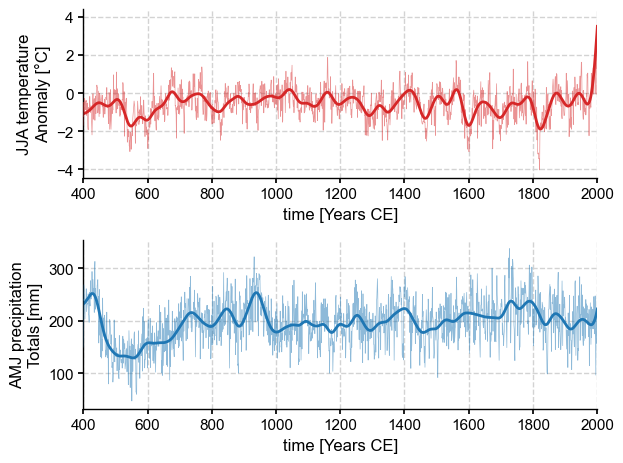

In [12]:
# a quick plot of the JJA temperature and AMJ precipitation.  
fig, axBu = plt.subplots(2,1)

ts_bu.plot(mute = True,color = 'C3',xlim= (400,2000),linewidth=0.5,alpha = 0.5,zorder = 10,ax = axBu[0])
ts_bu.filter(cutoff_freq=1/60, method = 'butterworth').plot(ax = axBu[0],color = 'C3')

ts_bu_pp.plot(mute = True,color = 'C0',xlim= (400,2000),linewidth=0.5,alpha = 0.5,zorder = 10,ax = axBu[1])
ts_bu_pp.filter(cutoff_freq=1/60, method = 'butterworth').plot(ax = axBu[1],color = 'C0')

plt.tight_layout()
pyleo.showfig(fig, close = True)

### Paleotemperature reconstruction for the NE Adriatic
Now we import the speleothem $\delta^{18}O$ record from SV1 stalagmite of the Grotta Savi site [Frisia et al. (2005)](https://doi.org/10.1080/03009480500231336)

In [13]:
# importing the Grotta Savi Dataset
gs_speleo = pd.read_excel('data/proxies/SV1-DB_only.xls',skiprows=[1])

# convert the d18O record to  pyleo.Series object
grotta_savi = pyleo.Series(value= gs_speleo.del18O,
                           value_unit='‰ VPDB',
                           value_name='$\delta^{18}$O',
                           time_name="time",
                           time_unit='Year CE',
                           time=gs_speleo['Age AD'])

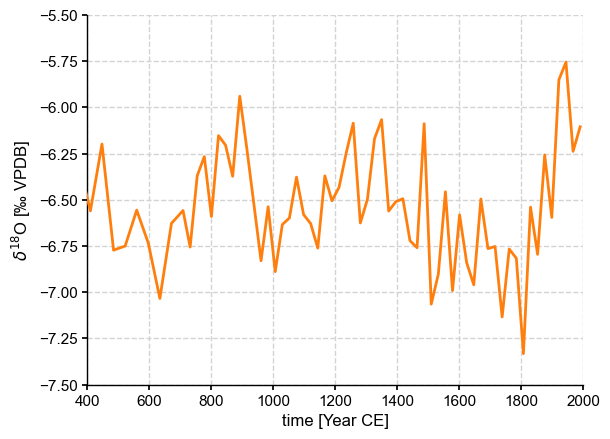

In [14]:
# a quick plot of d18O record
fig, axSavi = plt.subplots()
grotta_savi.plot(mute = True,color = 'C1',xlim= (400,2000),ylim = (-7.5,-5.5),zorder = 10,ax = axSavi)

pyleo.showfig(fig, close = True)

### Reading and plotting the cave ice record
Here we read the output of the OxCal model for M-17 cave. 

In [15]:
# read the oxcal output
M17 = ox.LoadFile('data/age_model/IntCal20_KDE_Models_Phases_NE_Adriatic.js')
kde_M17  = M17['ocd'][1]   # the kernel density object
start_M17 = M17['ocd'][5]  # boundary object
end_M17 = M17['ocd'][24]  # boundary object

In [16]:
# designing a helper function to plot an axis either on the right or left of the plot 
# they will be alternating on the final plot.
def PlotOnSide(ax,side,colour = 'C1'):
    if side == 'left':
        opp = 'right'
    else:
        opp = 'left'
        ax.yaxis.tick_right()

    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.xaxis.set_ticks([])
    ax.grid()
    ax.yaxis.set_label_position(side)
    ax.spines[side].set_visible(True)
    ax.spines[opp].set_visible(False)
    ax.set_xlabel(None)
    ax.yaxis.label.set_color(colour)
    ax.tick_params(axis='y', colors=colour)

### Putting it all together in one summary figure.

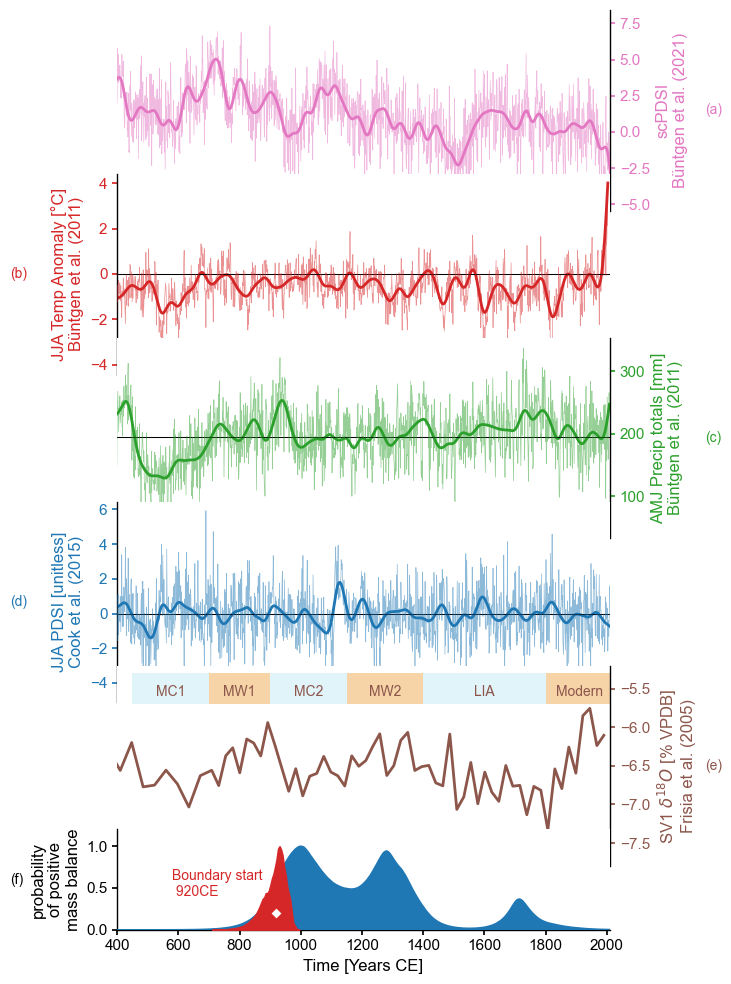

In [17]:
fig = plt.figure(figsize = (8, 10))

# set up the subfigures height ratios
gs = GridSpec(6, 1, height_ratios=[3,3,3, 3, 3, 1.5])

# scPDSI Central Europe Buentgen 2021
axBu2 = fig.add_subplot(gs[0])
scPDSI.plot(mute = True,color = 'C6',xlim= (400,2010),zorder = 10,ax = axBu2, linewidth = 0.5, alpha = 0.5)
scPDSI.filter(cutoff_freq=1/50,method = 'butterworth').plot(mute = True,color = 'C6',xlim= (400,2010),zorder = 10,ax = axBu2)
PlotOnSide(axBu2,'right','C6')
axBu2.set_ylabel("scPDSI\nBüntgen et al. (2021)",color = 'C6')



# Unterer Grindelwalder gletscher length changes
#axUgw = fig.add_subplot(gs[0])
#ts_ugw.plot(mute = True,color = 'black',xlim= (400,2010),ylim = (-50,2300),zorder = 10,ax = axUgw)
#PlotOnSide(axUgw,'right','black')
#axUgw.spines['top'].set_visible(True)

# Buentgen temperature reconstruction
axBuT = fig.add_subplot(gs[1])
ts_bu.plot(ax = axBuT,linewidth=0.5,color = 'C3',xlim= (400,2010),alpha=0.5,zorder= 10)
ts_bu.filter(cutoff_freq=1/60,method = 'butterworth').plot(ax =axBuT,color = 'C3')
axBuT.axhline(y=0,lw=0.75,color = 'k')
axBuT.set_ylabel("JJA Temp Anomaly [°C]\nBüntgen et al. (2011)",color = 'C3')
PlotOnSide(axBuT,'left','C3')

# Buentgen precipitation reconstruction
axBuPP = fig.add_subplot(gs[2])
ts_bu_pp.plot(ax = axBuPP,linewidth=0.5,color = 'C2',xlim= (400,2010),alpha=0.5,zorder= 10)
ts_bu_pp.filter(cutoff_freq=1/60,method = 'butterworth').plot(ax =axBuPP,color = 'C2')
axBuPP.axhline(y=ts_bu_pp.slice((1901,2012)).value.mean(),lw=0.75,color = 'k')
PlotOnSide(axBuPP,'right','C2')
axBuPP.set_ylabel("AMJ Precip totals [mm]\nBüntgen et al. (2011)",color = 'C2')

# Palmer Drought Severity Index reconstruction 
axPDSI = fig.add_subplot(gs[3])
ts_mean.plot(color = 'C0',ax = axPDSI,xlim= (400,2010),linewidth=0.5,alpha = 0.5,zorder = 10)
ts_mean.filter(cutoff_freq=1/60,method = 'butterworth').plot(ax =axPDSI,color = 'C0')
axPDSI.axhline(y=0,lw=0.75,color = 'k')
PlotOnSide(axPDSI,'left','C0')
axPDSI.set_ylabel("JJA PDSI [unitless]\nCook et al. (2015)",color = 'C0')

# Grotta Savi reconstruction
axSavi = fig.add_subplot(gs[4])
grotta_savi.plot(ax = axSavi,color = 'C5',xlim= (400,2010),ylim = (-7.8,-5.2),zorder= 100)
PlotOnSide(axSavi,'right','C5')
axSavi.set_ylabel("SV1 $\delta^{18}O$ [% VPDB]\nFrisia et al. (2005)",color = 'C5')
axSavi.yaxis.set_ticks(np.arange(-7.5,-5,0.5))

# Kernel density estimate
axM17 = fig.add_subplot(gs[5])
KDE_plot,med = ox.FillBetween(axM17, kde_M17, color= "C0", **{'zorder':50})
s_plot,s_med = ox.FillBetween(axM17, start_M17, median= True, color= "C3",**{'zorder':100})
axM17.set_ylabel("probability\nof positive\nmass balance")
axM17.set_xlim(400,2010)
axM17.set_ylim(0,1.2)
axM17.text(580, 0.4, 'Boundary start\n {:.0f}CE'.format(s_med), color= "C3",fontsize=10)
axM17.set_xlabel("Time [Years CE]")
axM17.grid()


# set up a color scheme and period boundaries
periods = {'MC1':(450,700,'cold'),
            'MC2':(900,1150,'cold'),
            'MW1':(700,900,'warm'),
            'MW2':(1150,1400,'warm'),
            'LIA':(1400,1800,'cold'),
          'Modern':(1800,2020,'warm')}
scheme = {'cold':'#e1f4fa','warm':'#f7d4a8'}
    
# Write some labels
for c,(ax,l, col) in enumerate(zip((axBu2,axBuT,axBuPP,axPDSI,axSavi,axM17),'abcdef',('C6','C3','C2','C0','C5','k'))):
    ylim = ax.get_ylim()
    anchor = ylim[1] - 0.5 * (ylim[1]-ylim[0])
    if c % 2 == 1:
        x = 50
    else: 
        x = 2320
    ax.text(x,anchor,s = '({})'.format(l),va = 'center',ha = 'left', fontsize = 10, color = col)


# label historical periods
for name,p in periods.items():
    axSavi.text((p[0]+p[1])/2, -5.6, name,color = 'C5', ha = 'center', fontsize = 10)
    r = Rectangle((p[0],-5.7),p[1]-p[0],0.4,facecolor = scheme[p[2]],zorder = 0)
    axSavi.add_table(r)

    # Sub-plot spacing adjustments
plt.tight_layout()
plt.subplots_adjust(hspace =-0.2)

# Saving the figure and closing

plt.savefig("outputs/f09.pdf",dpi=300,transparent=True)
plt.savefig("../reports/M17_manuscript/figures/f09.pdf",dpi=300,transparent=True)

pyleo.showfig(fig, close = True)